# libraddask Template for Radiative Transfer

## Prepare for Python

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pytz
import copy # required for deepcopy

from dask.distributed import Client # For contacting the dask scheduler
import libraddask.rad.librad as librad

import pprint
pp = pprint.PrettyPrinter(indent=4)

%matplotlib inline

## Set up and Execute a Scenario or Case

In [2]:
# Create a blank libRadtran case
# with a name for this case
S3 = librad.Case(casename='AerAng600to900nm')

# Set revision
revision = '00A'

# Choose basic atmospheric profile
atmos_profile = '../data/atmmod/afglmw.dat'
# mid-latitude winter standard atmosphere
S3.set_option('atmosphere_file', atmos_profile)  

# Change to the Thuillier spectrum and set wavelength range appropriately
# these files must be present on the server, relative to the bin directory
solar_toa_file = '../data/solar_flux/Solar_irradiance_Thuillier_2002.txt'
solar_toa_file = '../data/solar_flux/kurudz_1.0nm.dat'

# Choose start and stop wavelengths and minimum edge margin in nm
wv_minimum_range = [[385.0, -2.0], [955.0, 2.0]]
S3.set_option('source solar', solar_toa_file)
S3.set_option('wavelength', 600.0, 900.0)

# Set up dates and times
# Overpass date and time down to second
overpass_datetime = datetime.datetime(2016, 6, 5, 7, 42, 31, tzinfo=pytz.utc)  
overpass_datestr = overpass_datetime.strftime('%Y%m%d')
# Get the day of year
day_of_year = int(overpass_datetime.strftime('%j'))

results_folder = 'ResultsS3on' + overpass_datestr + 'Rev' + revision

# Choose solver
S3.set_option('rte_solver disort')

# Set ground altitude
S3.set_option('altitude', 1.225)  # ground altitude in km above sea level

# Set ground albedo
S3.set_option('albedo 0.5')

# Set up aerosol model using the Angstrom law
S3.set_option('aerosol_default')
aot_wv = np.array([440, 500, 675, 870], dtype=np.float)  # MicroTOPS measurement wavelengths
aot = np.array([0.703, 0.615, 0.362, 0.206])  # MicroTOPS measurements
# Fit Angstrom law to data
alpha, beta = librad.angstrom_law_fit(aot_wv, aot)
# Fit King Byrne formula
alpha_0, alpha_1, alpha_2 = librad.king_byrne_formula_fit(aot_wv, aot)
S3.set_option('aerosol_angstrom', alpha, beta)

# Set up viewing and solar geometry. Note that these angles are taken from the S3 product and special
# care has to be taken when putting geometry information into libRadtran
OAA = 104.01066  # deg. Observation azimuth angle (presumably relative to north through east, satellite from dam)
OZA = 14.151356  # deg. Observation zenith angle (satellite zenith angle as seen from the dam)
SAA = 38.719933  # deg. Solar azimuth angle (presumably relative to north through east)
SZA = 59.316036  # deg. Solar zenith angle

S3.set_option('sza', SZA)  # deg. This one is straightforward
# Now when entering solar and observation zenith angles, it is necessary to provide the azimuth of light propagation
# rather than the azimuth of the view direction, which is 180 deg different
#S3.set_option('phi0', 180.0 - SAA)  # solar radiation propagation azimuth from north through east
#S3.set_option('phi', OAA)  # This is the azimuth of the satellite as seen from the target - also azimuth of light propgation
#S3.set_option('umu', np.cos(np.deg2rad(OZA))) # For downward-looking (upward propagating), check that umu is positive

S3.set_option('verbose')  # Will produce a lot of diagnostic output on stderr

#S3.set_option('zout boa')  # Set altitude of output data
S3.purge = False  # Prevent purging of output files


In [3]:
# make a new case as a copy of existing
# If you use S3b = S3, both variables point to the same copy
# deepcopy operation required to create a new independent object

S3b = copy.deepcopy(S3)
# define a new spectral band, otherwise the same
S3b.name = 'AerAng650to800nm'
S3b.set_option('wavelength', 650.0, 800.0)
# S3b.set_option('aerosol_visibility', 5.0)

In [4]:
#print out the current file contents
# Case().__repr__() provides the same output as written to the file.
print(f'S3:\n{S3}\n')
print(f'S3b:\n{S3b}\n')

S3:
atmosphere_file ../data/atmmod/afglmw.dat
source solar ../data/solar_flux/kurudz_1.0nm.dat
wavelength 600.0 900.0
rte_solver disort
altitude 1.225
albedo 0.5
aerosol_default 
aerosol_angstrom 1.6848887536371142 0.18175118840581214
sza 59.316036
verbose 

S3b:
atmosphere_file ../data/atmmod/afglmw.dat
source solar ../data/solar_flux/kurudz_1.0nm.dat
wavelength 650.0 800.0
rte_solver disort
altitude 1.225
albedo 0.5
aerosol_default 
aerosol_angstrom 1.6848887536371142 0.18175118840581214
sza 59.316036
verbose 



In [5]:
# create dask Client method with scheduler serverURI (IP and port)
serverURI = '146.64.246.94:8786'
client = Client(serverURI)

# count number of workers, obtained from scheduler
number_of_processes = len(client.scheduler_info()['workers'])
print(f'Number of workers: {number_of_processes}')
print(f'Client cores: {client.ncores()} ')

# uncomment to see the detail
# pp.pprint(client.get_versions(check=True))

Number of workers: 8
Client cores: {'tcp://146.64.246.94:34397': 4, 'tcp://146.64.246.94:38009': 4, 'tcp://146.64.246.94:39663': 4, 'tcp://146.64.246.94:41169': 4, 'tcp://146.64.246.94:41399': 4, 'tcp://146.64.246.94:41797': 4, 'tcp://146.64.246.94:43815': 4, 'tcp://146.64.246.94:45191': 4} 


In [6]:
# do a run on the server using two cases
futuresRad = client.map(librad.Case.run, [S3, S3b])

# Gather results. This will wait for completion of all tasks.
S3List = client.gather(futuresRad)    

# check the return values
librad.check_uvspec_run_success(S3List)

All runs successful.


In [7]:
# extract to 
S3 = S3List[0]
S3b = S3List[1]

In [8]:
# Check for any errors by printing the return code and anything written to stderr
print(f'Return Codes : {S3.run_return_code} {S3b.run_return_code} ')
# print(f'Run({S3.name}) error (if any):\n{S3.stderr}')
# print(f'Run({S3b.name}) error (if any):\n{S3b.stderr}')

Return Codes : 0 0 


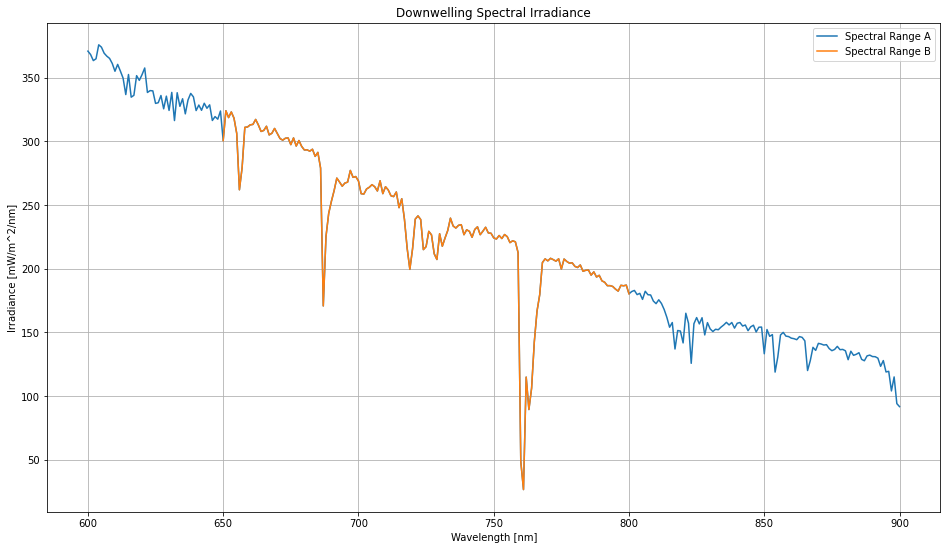

In [9]:
# now plot on the same graph
plt.figure(figsize=(16,9))
plt.plot(S3.wvl, S3.edn, S3b.wvl, S3b.edn)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Irradiance [mW/m^2/nm]')
plt.title('Downwelling Spectral Irradiance')
plt.legend(['Spectral Range A', 'Spectral Range B'])
plt.grid()
# plt.savefig('ednAerAng.pdf')

## Demonstrate King-Byrne and Angstrom Law

The run above was done using the Angstrom law parameters fitted to MicroTOPS measurements.
Now compare 

In [10]:
# Check the quality of the Angstrom Law and King-Byrne formula fits
the_wv = np.arange(350.0, 950.0, 10.0)  # Pick a wavelength range
the_aot = librad.king_byrne_formula(the_wv, alpha_0, alpha_1, alpha_2)  # Calculate King-Byrne 
aot_ang = librad.angstrom_law(the_wv, alpha, beta)  # Calculate Angstrom Law
print(f'Angstrom alpha={alpha} beta={beta}')
print(f'king_byrne alpha0={alpha_0} alpha1={alpha_1} alpha2={alpha_2}')


Angstrom alpha=1.6848887536371142 beta=0.18175118840581214
king_byrne alpha0=-1.9950667229251264 alpha1=-3.0186651652429806 alpha2=-1.2338155309188534


In [11]:
# Set up atmospheric model and base case
atm = librad.Case(casename='RoodeplaatTransmittance')

# mid-latitude winter
atm.set_option('atmosphere_file', '../data/atmmod/afglmw.dat')  

# solar_toa_file = '../data/solar_flux/Solar_irradiance_Thuillier_2002.txt'
# solar_toa_file = '../data/solar_flux/kurudz_1.0nm.dat'
# atm.set_option('source solar', solar_toa_file)

# Choose solver
atm.set_option('rte_solver', 'disort')

# Set ground altitude (BOA) above sea-level
atm.set_option('altitude', 1.225)  # km AMSL

# Set up aerosol model
atm.set_option('aerosol_default')
# Aerosol type above 2km
# atm.set_option('aerosol_vulcan', 1)  
# Angstrom aerosol
atm.set_option('aerosol_angstrom', alpha, beta)

atm.set_option('wavelength', 400.0, 900.0)

SZA = 59.316036  # deg. Solar zenith angle
atm.set_option('sza', SZA)  # deg. This one is straightforward
atm.set_option('output_quantity transmittance')
atm.purge = False  # Prevent purging of output files


In [12]:
print(f'atm:\n{atm}')

atm:
atmosphere_file ../data/atmmod/afglmw.dat
rte_solver disort
altitude 1.225
aerosol_default 
aerosol_angstrom 1.6848887536371142 0.18175118840581214
wavelength 400.0 900.0
sza 59.316036
output_quantity transmittance


In [13]:
# do a run on the server using two cases
futuresRad = client.map(librad.Case.run, [atm])

# Gather results. This will wait for completion of all tasks.
T3List = client.gather(futuresRad)    

# check the return values
librad.check_uvspec_run_success(T3List)

All runs successful.


For some unknown reason the transmittance from libRadtran comes out significantly **smaller** than what the Angstrom equation predicts.

In [14]:
T3a = T3List[0]
transm = T3a.edir[0:,0]
scaling = 3
txm = transm * scaling

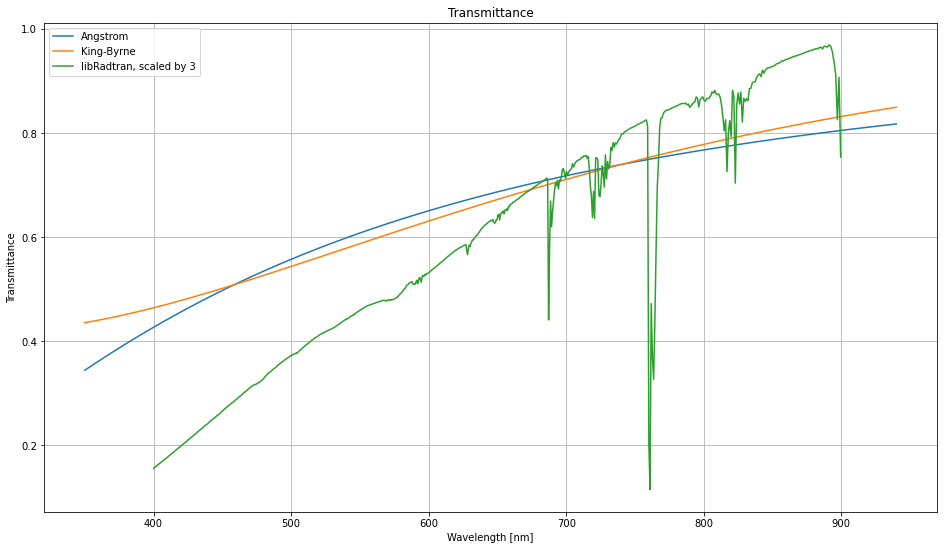

In [15]:
# Plot transmittance
plt.figure(figsize=(16,9))
plt.plot(the_wv, np.exp(- aot_ang))
plt.plot(the_wv, np.exp(- the_aot))
plt.plot(T3a.wvl, txm)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmittance')
plt.title('Transmittance')
plt.legend(['Angstrom','King-Byrne',f'libRadtran, scaled by {scaling}'])
plt.grid()


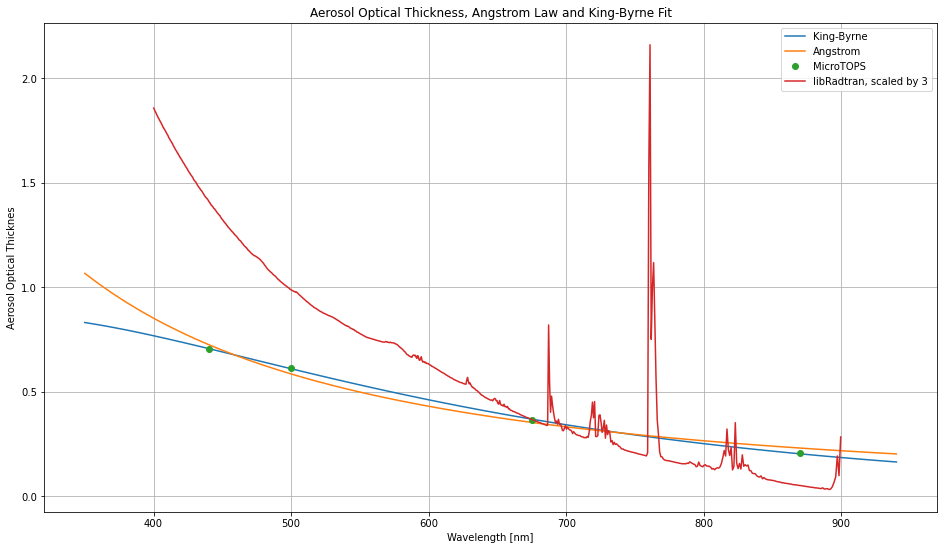

In [16]:
# Plot Angstrom Law and King-Byrne fitted curves with MicroTOPS measurements
plt.figure(figsize=(16,9))
plt.plot(the_wv, the_aot, the_wv, aot_ang, aot_wv, aot, 'o')
plt.plot(T3a.wvl, -np.log(txm) )
plt.xlabel('Wavelength [nm]')
plt.ylabel('Aerosol Optical Thicknes')
plt.title('Aerosol Optical Thickness, Angstrom Law and King-Byrne Fit')
plt.legend(['King-Byrne', 'Angstrom', 'MicroTOPS',f'libRadtran, scaled by {scaling}'])
plt.grid()


## Split Case

`librad.Case()` has the option to split a wavelength range into smaller sections.
These smaller sections can be executed on the server in parallel and the results merged afterwards.

In [17]:
# Split up into number of sub-cases depending on the number of cores and 
# other factors on the compute cluster
# use wavelength overlap of 1.0 nm
atm_list = atm.split_case_by_wavelength(number_of_processes, overlap=1.0)  

# Take a look at the splits
print('file contents:')
print(atm_list[0],end='\n\n')

print(f'Spectral ranges for {number_of_processes} processes:')
for i,item in enumerate(atm_list):
    print(f"process {i} range={item.tokens[item.options.index('wavelength')]}")

file contents:
atmosphere_file ../data/atmmod/afglmw.dat
rte_solver disort
altitude 1.225
aerosol_default 
aerosol_angstrom 1.6848887536371142 0.18175118840581214
wavelength 400.0 462.5
sza 59.316036
output_quantity transmittance

Spectral ranges for 8 processes:
process 0 range=['400.0', '462.5']
process 1 range=['461.5', '525.0']
process 2 range=['524.0', '587.5']
process 3 range=['586.5', '650.0']
process 4 range=['649.0', '712.5']
process 5 range=['711.5', '775.0']
process 6 range=['774.0', '837.5']
process 7 range=['836.5', '900.0']


In [18]:
# run the list of spectral ranges
futureRadBatch = client.map(librad.Case.run, atm_list)
atm_listrtn = client.gather(futureRadBatch) 
# check the return values
librad.check_uvspec_run_success(atm_listrtn)

All runs successful.


In [19]:
# Merge results for edir, which will be direct (specular) transmittance 
# in 'output transmittance' mode
wvl_atm_reptran, atm_reptran = \
    librad.Case.merge_caselist_by_wavelength(atm_listrtn, 'edir')


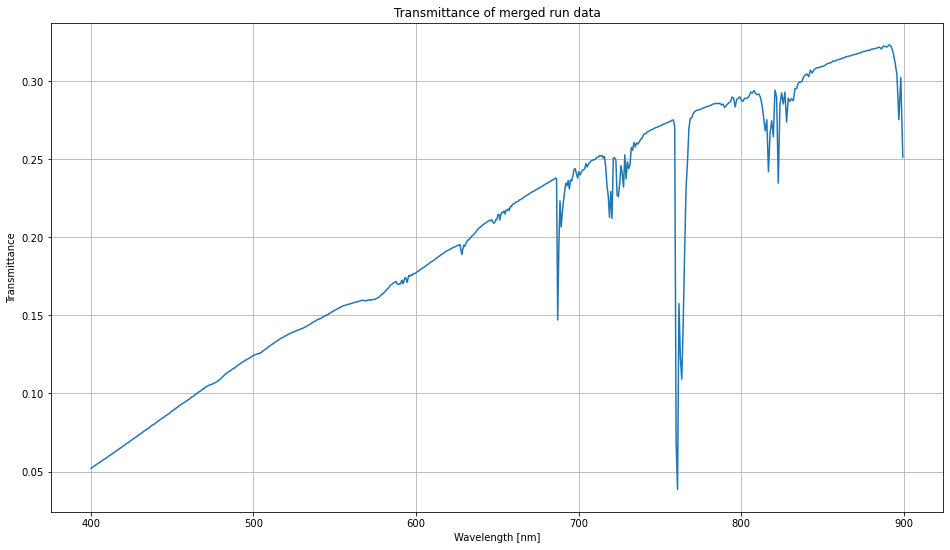

In [20]:
# Plot transmittance
plt.figure(figsize=(16,9))
plt.plot(wvl_atm_reptran, atm_reptran)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmittance')
plt.title('Transmittance of merged run data')
plt.grid()


## Shutting down the Client

When the client is no longer required, shut it down.

BUT: this also kills the scheduler and/or workers!

In [21]:
# client.shutdown()

In [22]:
# to get software versions
# https://github.com/rasbt/watermark
# An IPython magic extension for printing date and time stamps, version numbers, and hardware information. 
# you only need to do this once
# !pip install watermark

%load_ext watermark
%watermark -v -m -p numpy,matplotlib,datetime,pytz,dask,dask.distributed,libraddask -g 

CPython 3.7.6
IPython 7.13.0

numpy 1.18.1
matplotlib 3.2.1
datetime unknown
pytz 2019.3
dask 2.12.0
dask.distributed 2.12.0
libraddask 0.1.1

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : 678c42400523b7d730d6646132e271a7cacd8ab4
